# This notebook generates Figure 3d in the paper
## It also produces data used in Supplementary Table 1

In [1]:
# SPDX-License-Identifier: GPL-3.0-or-later

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import linregress
import matplotlib
font = {'size'   : 12}

matplotlib.rc('font', **font)
import conntility


# Samples cells from among L5PCs in the subvolume and gets scaling factors

In [4]:
import bluepysnap as bp
s = bp.Simulation('/gpfs/bbp.cscs.ch/project/proj83/scratch/home/tharayil/BlueRecording/examples/whiskerFlick/data/simulation/simulation_config.json')
circuit = s.circuit

In [5]:
nodes = circuit.nodes

In [11]:
# Loads a generator that produces the cell types for all cells in the subvolume
nFl = nodes.get('hex_O1',properties=['mtype'])


In [12]:
# Loads node ids for Layer 5 PC cells from each of the above regions

Fl = next(nFl)[1]

Fl = np.array(list(Fl[Fl['mtype'].isin(['L5_TPC:A','L5_TPC:B','L5_TPC:C','L5_UPC'])].index))[:,1].astype(int)



In [13]:
len(Fl) # Number of L5PCs, used in Supplementary Table 1

35144

In [14]:
import h5py

In [15]:
# Loads the weights file

coeffsFile = "/gpfs/bbp.cscs.ch/project/proj83/scratch/home/tharayil/BlueRecording/examples/whiskerFlick/electrodeFile/coeffs_eeg.h5"

coeffs = h5py.File(coeffsFile)

In [16]:
# Node ids from weights file
allNodeIds = coeffs['S1nonbarrel_neurons']['node_ids']

In [17]:
# Finds indices in the weights file of nodes in the selected regions

flIndex = np.where(np.isin(allNodeIds[:],Fl))[0]



In [18]:
np.random.seed(1776)

# Samples nodes from the selected regions

flIndex = np.sort(np.random.choice(flIndex,1000,replace=False))


FLshort = allNodeIds[:][flIndex]



In [19]:
# Finds offsets for the compartment weights for the selected nodes

flOffsets = [coeffs['S1nonbarrel_neurons']['offsets'][:][flIndex],coeffs['S1nonbarrel_neurons']['offsets'][:][flIndex+1]]



In [23]:
# Gets compartment weights for the selected nodes (shifted such that the minimum weight for each neuron is 0)

scaleFacFl = []

ranges = []


for i in range(len(flOffsets[0])):
    
    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,0]
    sfl -= np.min(sfl)

    scaleFacFl.append( sfl )

    ranges.append(np.percentile(sfl,90) - np.percentile(sfl,10))


In [1]:
r = np.mean(ranges) # Range of weights, used in supplementary table 1

NameError: name 'np' is not defined

# Loads 3d positions

In [68]:
path_to_positions = "compartment/c6374a94-59b9-468d-8958-f7c8f876e562/0/positions/"


In [69]:
# Loads positions for a subset of the selected nodes

allIds = [FLshort]

allIds = [s for item in allIds for s in item]

allIds = np.array(allIds)

import os

i = 0

for subfolder in os.listdir(path_to_positions):
    for file in os.listdir(path_to_positions+subfolder):
        
        if i > 10:
            break
        
        positions = pd.read_pickle(path_to_positions+subfolder+'/'+file)
        
        columns = np.array(list(positions.columns))[:,0]
        
        indices = np.where(np.isin(allIds,columns))[0]
        
        if len(indices)==0:
            continue
        
        idsInFile = allIds[indices]

        positions = positions[idsInFile]
        
        if i == 0:
            allPositions = positions
        else:
            allPositions = pd.concat((allPositions,positions),axis=1)
            
        i += 1
        

In [70]:
ids = np.unique(np.array(list(allPositions.columns))[:,0])

In [71]:
def getNeuronSegmentMidpts(position):
    '''
    Gets midpoints for a single neuron
    '''

    
    secIds = np.array(list(position.columns))
    uniqueSecIds = np.unique(secIds)

    for sId in uniqueSecIds: # Iterates through sections

        pos = position.iloc[:,np.where(sId == secIds)[0]]

        if sId == 0: # Implies that section is a soma, so we just take the position from the file

            newPos = pos
 
        elif np.shape(pos.values)[-1] == 1: # If there is only one point in the section, we just take the value
            newPos = pd.concat((newPos,pos),axis=1)

        else: # We take the midpoints of the values in the file, which are the endpoints of the segments
            pos = (pos.iloc[:,:-1]+pos.iloc[:,1:])/2

            newPos = pd.concat((newPos,pos),axis=1)

    return newPos

In [72]:
# Spatial positions of the electrodes

eeg = np.array([3996,-777,2423.97])
returnElectrode = np.array([2677,851,2947.32])


The following cell produces Figure 3d:

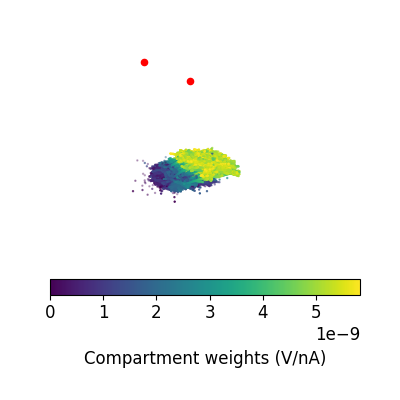

In [74]:
from matplotlib.gridspec import GridSpec


import types

plt.rcParams['axes.formatter.useoffset'] = False

fig = plt.figure(figsize=(4,4))

ax1 = fig.add_subplot(1,1,1,projection='3d')

#####
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for EEG
for i in ids[:100]:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFl
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHl
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULp
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values
        
    im = ax1.scatter(p[0],p[1],p[2],marker=marker,c=scale,s=.5)#,vmin=0,vmax=5e-9)
    
ax1.view_init(elev=9., azim=-85)

# Plots locations of electrodes
ax1.scatter(eeg[0],eeg[1],eeg[2],c='r',s=20)
ax1.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20) 

ax1.set_xlim((2801.1161576783625, 5500))
ax1.set_ylim((0, 1883.8635116069354))
ax1.set_zlim((-4332.110601382281, 914.4962633882312))


ax1.axis('off')

cb = plt.colorbar(im,fraction=0.25,location='bottom')

cb.set_label(label='Compartment weights (V/nA)',labelpad=20)
# cb.set_ticks([])
#####

plt.savefig('figures/neurons.png',dpi=600)